E:\UNI\D_Drive\PhD\Year_1\2021_02_05_OwnOEDmcPaper\Scripts\PLac

# Import all packages

In [1]:
using DifferentialEquations
using OrdinaryDiffEq
using DiffEqBase
using Sundials
using ODEInterfaceDiffEq
using Plots
using Measures
using CSV
using DataFrames
using Turing
using MCMCChains
using EasyFit
using StatsPlots
using LinearAlgebra
using Random
using Distributions
using OrdinaryDiffEq
Random.seed!(145975);
using CmdStan
using KernelDensity
using LaTeXStrings
using StatsBase
using JLD2
using BlackBoxOptim
using BlackBoxOptim: num_func_evals

set_cmdstan_home!("C:\\cmdstan\\cmdstan-2.30.0");

┌ Warning: Environment variable CMDSTAN_HOME not set. Use set_cmdstan_home!.
└ @ CmdStan C:\Users\dgomez\.julia\packages\CmdStan\2vwWj\src\CmdStan.jl:27


In [2]:
include("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\BayesianInference\\FunctionsBayesInfs.jl")
include("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\InitalParameterFitPriorDef\\ModelFunctionsAll.jl")
include("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\FunctionsBayesOED.jl")

redSamples (generic function with 2 methods)

# Define True Theta and Bounds

In [3]:
trueP = [48.0, 55.0,0.005911,0.01832,0.042171,0.5365,0.98047,0.991257,0.93335,0.008241,0.9943848,0.001974,   15];

bounds = [[48, 55, 0.001, 0.005, 0.042171, 0.5365, 0.98047, 0.991257, 0.93335, 0.008241, 0.7, 0.0008, 15],
          [48, 55, 0.01, 0.05, 0.042171, 0.5365, 0.98047, 0.991257, 0.93335, 0.008241, 1.2, 0.005, 15]];


InitsY0 = [450, 12599, 226];

boundY0 = [[450, 12599, 226],
           [450, 12599, 226]];

# Generate Pseudodata

## Define Experimental Details

In [4]:
Nexp = 4;

Random.seed!(8934547);
PyrCons = round.(rand(Uniform(0,40), Nexp), digits = 1).*1000

4-element Vector{Float64}:
 13800.0
   800.0
 29400.0
  6800.0

In [5]:
dat32mM = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ProcessedData\\4Mil_Dat.csv", DataFrame));

In [6]:
tsC2 = dat32mM[:,1]
ts = 0:tsC2[end];

ivssAll = Array{Any}(undef, Nexp);
for i in 1:Nexp
    ivssAll[i] = [PyrCons[i], 0, 0, InitsY0[1], InitsY0[2], InitsY0[3], 0, 0, 0, 0, 0, PyrCons[i], 0, PyrCons[i]*(trueP[end]*0.12)];;
end
samps = convert.(Int, tsC2);


## Simulate Experiments and Extract Observables

In [10]:
SimulsAll = Array{Any}(undef, Nexp,3);
for i in 1:Nexp
    SimulsAll[i,1], SimulsAll[i,2], SimulsAll[i,3]  = PyruvateHP_NMR_SolveAllCp(ts, vcat(trueP, 0), ivssAll[i], samps);
end

In [11]:
ObsS = Array{Any}(undef, Nexp,2);
for i in 1:Nexp
    ObsS[i,1] = SimulsAll[i,1][:,14,1]; # Pyruvate HP
    ObsS[i,2] = SimulsAll[i,1][:,13,1]; # Lactate HP
end


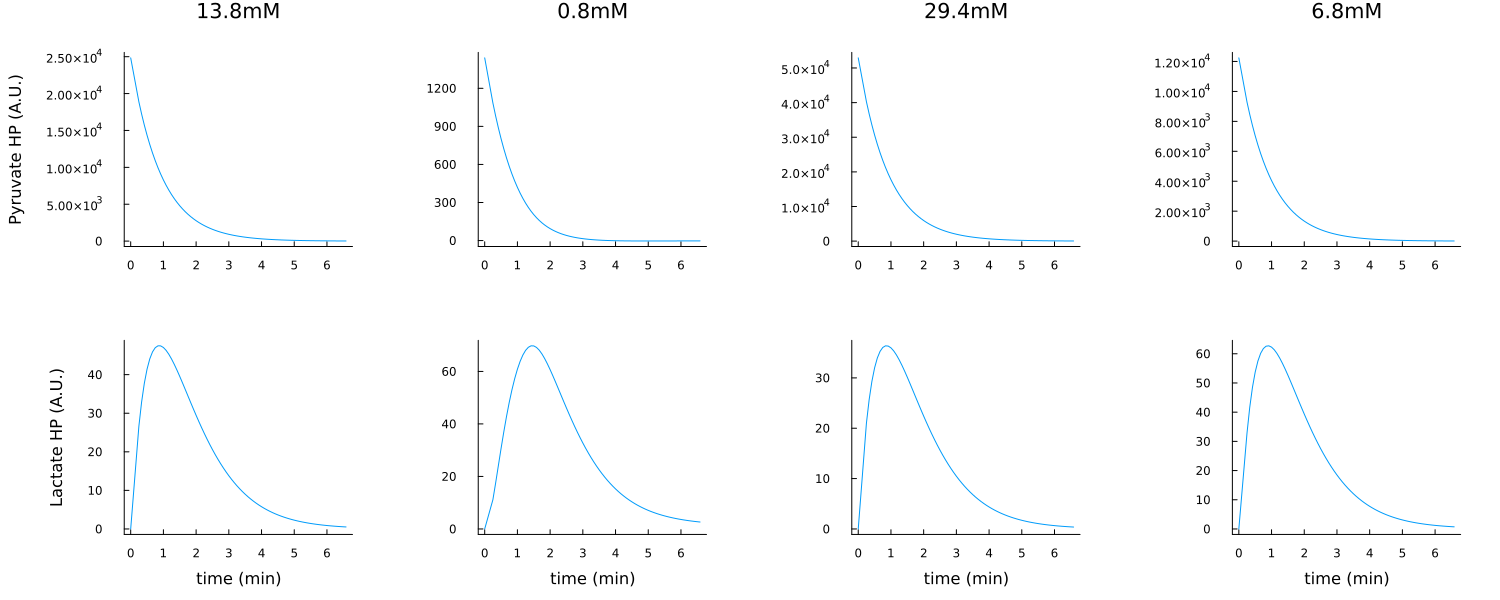

In [12]:
pp1 = plot(samps./60, ObsS[1,1], label = "", title = string(PyrCons[1]/1000)*"mM", ylabel = "Pyruvate HP (A.U.)")
pp2 = plot(samps./60, ObsS[1,2], label = "", ylabel = "Lactate HP (A.U.)", xlabel = "time (min)")

PP1 = plot(pp1,pp2, layout = (2,1))

pp1 = plot(samps./60, ObsS[2,1], label = "", title = string(PyrCons[2]/1000)*"mM")
pp2 = plot(samps./60, ObsS[2,2], label = "", xlabel = "time (min)")

PP2 = plot(pp1,pp2, layout = (2,1))

pp1 = plot(samps./60, ObsS[3,1], label = "", title = string(PyrCons[3]/1000)*"mM")
pp2 = plot(samps./60, ObsS[3,2], label = "", xlabel = "time (min)")

PP3 = plot(pp1,pp2, layout = (2,1))

pp1 = plot(samps./60, ObsS[4,1], label = "", title = string(PyrCons[4]/1000)*"mM")
pp2 = plot(samps./60, ObsS[4,2], label = "", xlabel = "time (min)")

PP4 = plot(pp1,pp2, layout = (2,1))

plot(PP1, PP2, PP3, PP4, layout = (1,4), grid = false, size = (1500,600), margin = 8mm)

## Simulate Noise

In [13]:
sigm1=0.12; # 10% additive heteroscedastic noise
sigm2=0.075;


Random.seed!(45659211); 

SolN1NoiseHet = zeros(length(samps),Nexp,2);
basemat = zeros(length(samps),Nexp,2);

i = 1

for i in 1:Nexp
    basemat[:,i,1] = ObsS[i,1]'.*sigm1; # introduce new diagonal matrices
    basemat[:,i,2] = ObsS[i,2]'.*sigm2;

    for zer in collect(1:length(samps)) # To avoid having standard deviations of 0
        if basemat[zer,i,1]<=1
            basemat[zer,i,1] = 1;
        end
        if basemat[zer,i,2]<=1
            basemat[zer,i,2] = 1;
        end
    end

    SolN1NoiseHet[:,i, 1] = ObsS[i,1]#+rand(MvNormal(zeros(length(samps)),basemat[:,i,1]));
    SolN1NoiseHet[:,i, 2] = ObsS[i,2]+rand(MvNormal(zeros(length(samps)),basemat[:,i,2]));
    SolN1NoiseHet[1,i, 2] = 0;
end

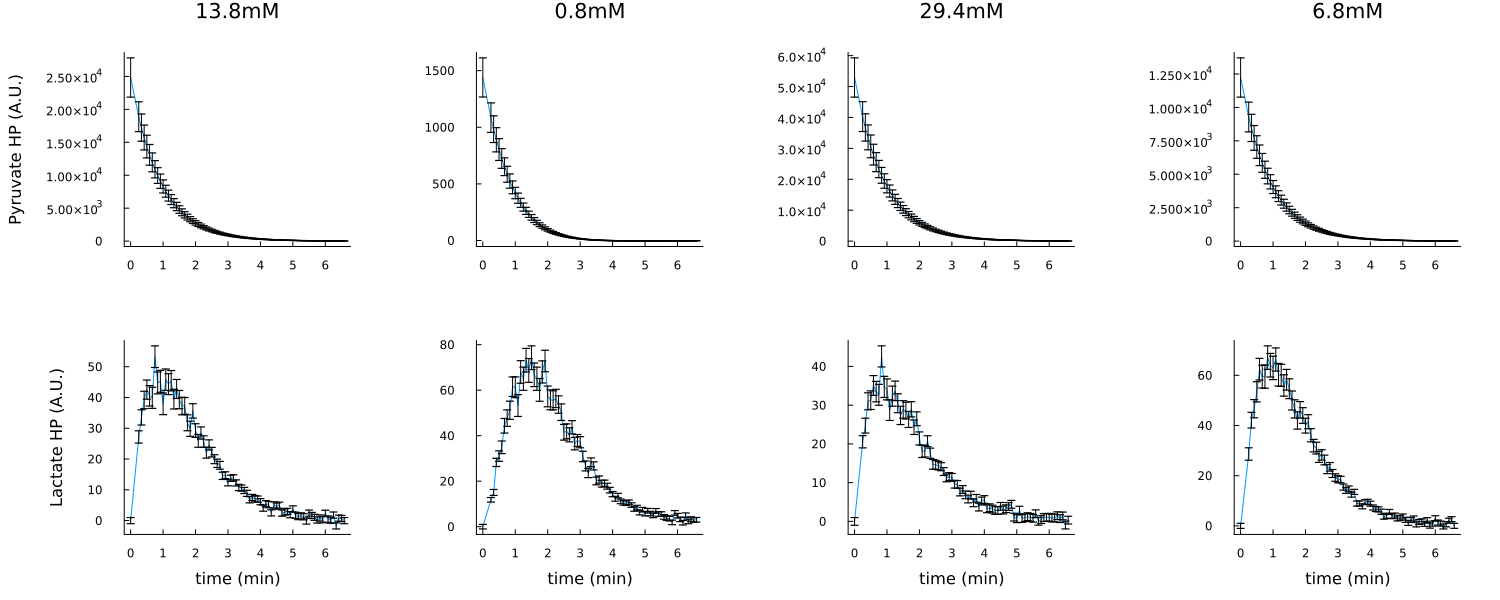

In [14]:
pp1 = plot(samps./60, SolN1NoiseHet[:,1, 1], yerror = basemat[:,1,1], label = "", title = string(PyrCons[1]/1000)*"mM", ylabel = "Pyruvate HP (A.U.)")
pp2 = plot(samps./60, SolN1NoiseHet[:,1, 2], yerror = basemat[:,1,2], label = "", ylabel = "Lactate HP (A.U.)", xlabel = "time (min)")

PP1 = plot(pp1,pp2, layout = (2,1))

pp1 = plot(samps./60, SolN1NoiseHet[:,2, 1], yerror = basemat[:,2,1], label = "", title = string(PyrCons[2]/1000)*"mM")
pp2 = plot(samps./60, SolN1NoiseHet[:,2, 2], yerror = basemat[:,2,2], label = "", xlabel = "time (min)")

PP2 = plot(pp1,pp2, layout = (2,1))

pp1 = plot(samps./60, SolN1NoiseHet[:,3, 1], yerror = basemat[:,3,1], label = "", title = string(PyrCons[3]/1000)*"mM")
pp2 = plot(samps./60, SolN1NoiseHet[:,3, 2], yerror = basemat[:,3,2], label = "", xlabel = "time (min)")

PP3 = plot(pp1,pp2, layout = (2,1))

pp1 = plot(samps./60, SolN1NoiseHet[:,4, 1], yerror = basemat[:,4,1], label = "", title = string(PyrCons[4]/1000)*"mM")
pp2 = plot(samps./60, SolN1NoiseHet[:,4, 2], yerror = basemat[:,4,2], label = "", xlabel = "time (min)")

PP4 = plot(pp1,pp2, layout = (2,1))

plot(PP1, PP2, PP3, PP4, layout = (1,4), grid = false, size = (1500,600), margin = 8mm)

## Generate CSV Files For PseudoData

In [15]:
# Observables
for i in 1:Nexp
    Observables = zeros(length(samps),5);
    Observables[:,1] = samps;
    Observables[:,2] = SolN1NoiseHet[:,i, 1];
    Observables[:,3] = basemat[:,i, 1];
    Observables[:,4] = SolN1NoiseHet[:,i, 2];
    Observables[:,5] = basemat[:,i, 2];
    obs_head = ["time","Pyr_MEAN","Pyr_STD","Lac_MEAN","Lac_STD"];

    df1 = DataFrame(Observables, :auto);
    rename!(df1, [obs_head[i] for i in 1:5]);
    CSV.write(string("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\PseudoData\\CompReprFixedPars_Ran",i,"_Observables_Pyr",string(string(PyrCons[i]/1000)),"mM.csv"), df1);
end

# Bayesian Inference 1

## Extract Data

In [19]:
mainpath = "C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\PseudoData\\";
i = 1;
paths = [mainpath*"CompReprFixedPars_Ran"*string(i)*"_Observables_Pyr"*(string(PyrCons[i]/1000))*"mM.csv"]

1-element Vector{String}:
 "C:\\IBECPostDocDrive\\2024_01_16_" ⋯ 84 bytes ⋯ "_Ran1_Observables_Pyr13.8mM.csv"

In [20]:
Random.seed!(231549);
global dat = restructDatInfCompRep_FixedSF(paths, InitsY0[1], InitsY0[2], InitsY0[3], 15)

Dict{String, Any} with 14 entries:
  "Means"  => [24840.0; 18883.6; … ; 19.8071; 18.0714;;; 0.0; 27.1767; … ; 0.66…
  "stsl"   => [78;;]
  "obSta"  => [1 2]
  "sts"    => [0; 15; … ; 390; 395;;]
  "obser"  => 2
  "Y0us"   => [13800.0; 0.0; … ; 0.0; 24840.0;;]
  "ts"     => [1.0e-20; 1.0; … ; 394.0; 395.0;;]
  "itp"    => [0.0]
  "ncells" => [0;;]
  "stslm"  => 78
  "tml"    => 396
  "Erros"  => [2980.8; 2266.03; … ; 2.37686; 2.16857;;; 1.0; 1.99542; … ; 1.0; …
  "m"      => 1
  "nts"    => [395;;]

## Prior Prediction

In [12]:
priorTheta = Array{Any}(undef, 13);
priotY0 = Array{Any}(undef, 3);

priotY0[1] = Truncated(Normal(650, 260), 0, 1500);
priotY0[2] = Truncated(Normal(16000, 6400), 0, 4e4);
priotY0[3] = Truncated(Normal(550, 275), 0, 2000);

priorTheta[1] = Normal(40.92, 10); priorTheta[2] = Normal(51.23, 10); priorTheta[3] = Truncated(Normal(0.0055, 0.00275), 0,2); priorTheta[4] = Truncated(Normal(0.0275, 0.01375), 0,2); 
priorTheta[5] = Truncated(Normal(0.045, 0.0225), 0,2); priorTheta[6] = Truncated(Normal(0.45, 0.225), 0,2); priorTheta[7] = Truncated(Normal(0.95, 0.475), 0,2); 
priorTheta[8] = Truncated(Normal(0.95, 0.475), 0,2); priorTheta[9] = Truncated(Normal(0.95, 0.475), 0,2); priorTheta[10] = Truncated(Normal(0.0085, 0.00425), 0,2);
priorTheta[11] = Truncated(Normal(0.95, 0.475), 0,2); priorTheta[12] = Truncated(Normal(0.0029, 0.00145), 0,2); priorTheta[13] = Normal(18.5, 2.29);

In [13]:
sampsTh = zeros(8000, 13);
sampsY0 = zeros(8000, 3);

Random.seed!(657986354); 

for i in 1:13
    sampsTh[:,i] = rand(priorTheta[i], 8000);
end
for i in 1:3
    sampsY0[:,i] = rand(priotY0[i], 8000);
end

In [14]:
sampsTh[:,1] .= trueP[1];
sampsTh[:,2] .= trueP[2];
sampsTh[:,5] .= trueP[5];
sampsTh[:,6] .= trueP[6];
sampsTh[:,7] .= trueP[7];
sampsTh[:,8] .= trueP[8];
sampsTh[:,9] .= trueP[9];
sampsTh[:,10] .= trueP[10];
sampsTh[:,13] .= trueP[13];

sampsY0[:,1] .= InitsY0[1];
sampsY0[:,2] .= InitsY0[2];
sampsY0[:,3] .= InitsY0[3];

In [24]:
simsPrior = Array{Any}(undef, 8000);


for i in 1:8000
    tsC2 = dat["sts"];
    ts = 0:tsC2[end];
    ivss = [dat["Means"][1,1,1]/(sampsTh[i,end]*0.12), 0, 0, sampsY0[i,1], sampsY0[i,1], sampsY0[i,1], 0, 0, 0, 0, 0, dat["Means"][1,1,1]/(sampsTh[i,end]*0.12), 0, dat["Means"][1,1,1]];;
    samps = convert.(Int, tsC2);

    SimulsAll, SimulsAll2, SimulsAll3 = PyruvateHP_NMR_SolveAllCp(ts, vcat(sampsTh[i,1:end], 0), ivss, samps);

    simsPrior[i] = SimulsAll;
end

In [25]:
# Dims = Up/Down, Observable, Experiment
PriorQuant = Array{Any}(undef,2,1,1);
lacPirorSims = zeros(size(simsPrior[1])[1], 8000)
[lacPirorSims[:,i] = simsPrior[i][:,13,1] for i in 1:8000 ];

for k in 1:1
    for m in 1:1
        PriorQuant[1,k,m] = [percentile(lacPirorSims[j,:], 99.5) for j in 1:size(lacPirorSims)[1]]; # Up
        PriorQuant[2,k,m] = [percentile(lacPirorSims[j,:], 0.5 ) for j in 1:size(lacPirorSims)[1]]; # Down
    end
end


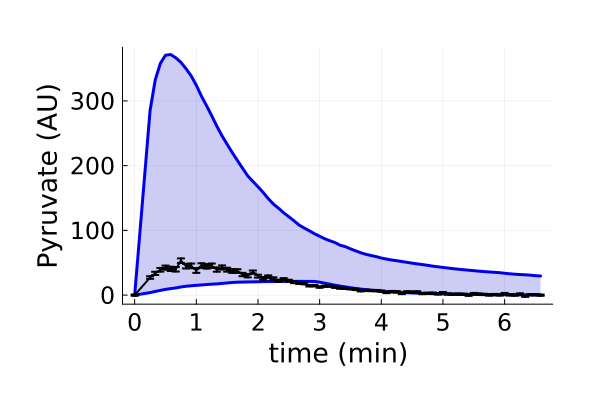

In [26]:
pr = plot(tsC2./60, PriorQuant[1], label = "", color = "blue", linewidth = 3,
    margin=10Plots.mm,xtickfont=font(16), ytickfont=font(16), guidefont=font(18), titlefont=font(18),
    xlabel = "time (min)", ylabel = "Pyruvate (AU)")
  plot!(tsC2./60, PriorQuant[2], label = "", color = "blue", linewidth = 3)
  plot!(tsC2./60, PriorQuant[1], fillrange=PriorQuant[2], label="", color="blue3", fillalpha=0.2)

  plot!(dat["sts"]./60, dat["Means"][:,1,2], yerror = dat["Erros"][:,1,2], linewidth = 2, colour = "black", label = "")

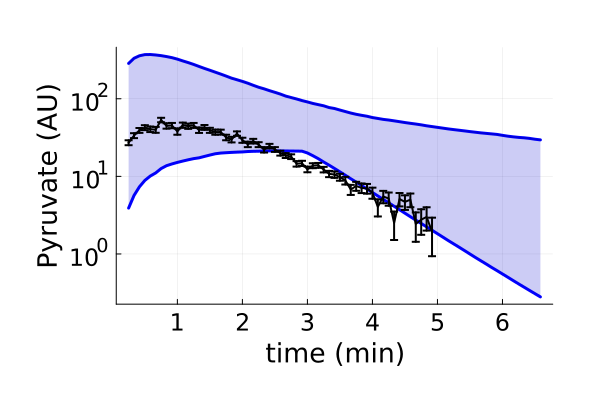

In [27]:
pr = plot(tsC2[2:end]./60, PriorQuant[1][2:end], label = "", color = "blue", linewidth = 3,
    margin=10Plots.mm,xtickfont=font(16), ytickfont=font(16), guidefont=font(18), titlefont=font(18),
    xlabel = "time (min)", ylabel = "Pyruvate (AU)")
  plot!(tsC2[2:end]./60, PriorQuant[2][2:end], label = "", color = "blue", linewidth = 3)
  plot!(tsC2[2:end]./60, PriorQuant[1][2:end], fillrange=PriorQuant[2][2:end], label="", color="blue3", fillalpha=0.2, yaxis=:log)

  plot!(dat["sts"][2:end-20]./60, dat["Means"][:,1,2][2:end-20], yerror = dat["Erros"][:,1,2][2:end-20], linewidth = 2, colour = "black", label = "", yaxis=:log)

  
display(pr)

## MLE to obtain a good first guess for inference

In [28]:
function ObjectFunctMECp_MLE(p)

    # Define parameter vectors for each amount of cells (last parameter is a time delay, not used in here)
    pD2 = vcat(p[1:end-3], 0);

    # Define time vector
    t2cor = dat["sts"];

    # Define equaly-spaced time vector
    ts1 = collect(0:t2cor[end]);

    # Define initial value for simulation (use of experimental mean)
    ivss1 = [dat["Means"][1,1,1]/(ScFm*0.12), 0, dat["Means"][1,1,2]/(ScFm*0.12), p[end-2], p[end-1], p[end], 0, 0, 0, 0, 0, dat["Means"][1,1,1]/(ScFm*0.12), dat["Means"][1,1,2], dat["Means"][1,1,1]];

    # Convert sampling vector to integer to extract correct elements from simulation
    samps1 = convert.(Int, t2cor);

    # Simulate
    SimOnTime1, SimOffTime1, SimAll1  = PyruvateHP_NMR_SolveAllCp(ts1, pD2, ivss1, samps1);
    
    mm22 = sum((-1/2) .* (log(2*pi) .+ log.(dat["Erros"][:,1,2].^2) .+ ((SimOnTime1[:,13] .- dat["Means"][:,1,2]).^2)./(dat["Erros"][:,1,2].^2)));

    # obj = (mm21+mm22)*(mm11+mm12);
    if p[end-2] >= p[end-1]
        mm22 = mm22*10;
    end
    obj = -(mm22);

    
    return(obj)

end


ObjectFunctMECp_MLE (generic function with 1 method)

In [30]:
global ScFm = 15;
p = [48, 55, 0.044, 0.02, 0.02, 0.001, 0.01, 0.0003, 0.0001, 0.0002, 1e-1, 1e-6, 15, 50/(15*0.12), 5000/(15*0.12), 700/(15*0.12)];
ObjectFunctMECp_MLE(p)

1846.0062079645083

In [32]:
Iters = 1;
CCsT = Array{Any}(undef,Iters);
FitsT = Array{Any}(undef,Iters);

In [33]:
i=1
fitness_progress_history = Array{Tuple{Int, Float64},1}()
callback = oc -> push!(fitness_progress_history, (num_func_evals(oc), best_fitness(oc)))

resM = bboptimize(ObjectFunctMECp_MLE; SearchRange = vcat([(bounds[1][i], bounds[2][i]) for i in 1:13], [(boundY0[1][i], boundY0[2][i]) for i in 1:3]), # T1_X, T1_P, kin, kpl, kf, kr, a1, a2, a3, b1, b2, b3
        MaxTime = 60*1, method = :adaptive_de_rand_1_bin, 
        CallbackFunction = callback, CallbackInterval = 0.0)

CCsT[i] = fitness_progress_history;
FitsT[i] = resM;

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.51 secs, 98 evals, 55 steps, improv/step: 0.364 (last = 0.3636), fitness=138.661774175
1.01 secs, 163 evals, 100 steps, improv/step: 0.310 (last = 0.2444), fitness=138.661774175
1.51 secs, 289 evals, 198 steps, improv/step: 0.333 (last = 0.3571), fitness=138.661774175
2.01 secs, 403 evals, 307 steps, improv/step: 0.345 (last = 0.3670), fitness=137.659132651
2.51 secs, 513 evals, 425 steps, improv/step: 0.322 (last = 0.2627), fitness=136.092132957
3.02 secs, 632 evals, 566 steps, improv/step: 0.313 (last = 0.2837), fitness=136.092132957
3.52 secs, 745 evals, 704 steps, improv/step: 0.307 (last = 0.2826), fitness=135.716608996
4.02 secs, 861 evals, 839 steps, improv/step: 0.291 (last = 0.2074), fitness=135.526331752
4.52 secs, 970 evals, 969 steps, improv/step: 0.286 (last = 0.2538), f

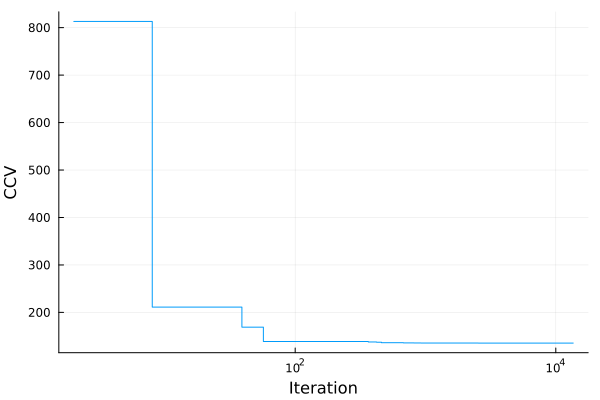

In [34]:
# Plot convergence curve
pl=plot(CCsT[1], xaxis=:log, linetype=:step, label = "", xlabel = "Iteration", ylabel = "CCV")
display(pl)

In [35]:
parfitT = zeros(16, Iters);
for i in 1:Iters
    parfitT[:,i] = best_candidate(FitsT[i]);
end
bestPind = findfirst([CCsT[i][end][2] for i in 1:length(CCsT)] .== minimum([CCsT[i][end][2] for i in 1:length(CCsT)]))
ppT = parfitT[:,bestPind]

16-element Vector{Float64}:
    48.0
    55.0
     0.0071800651692531985
     0.017741010556370732
     0.042171
     0.5365
     0.98047
     0.991257
     0.93335
     0.008241
     0.7000138193600124
     0.0008000000634587043
    15.0
   450.0
 12599.0
   226.0

In [36]:
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\MLEResults\\resMTRRCmpFP_ScF_Rand1.jld2", "FitsT",FitsT)
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\MLEResults\\resMVectTRRCmpFP_ScF_Rand1.jld2", 
        "resMMat",parfitT, "CCsT", CCsT)

In [37]:
ppT = JLD2.load("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\MLEResults\\resMVectTRRCmpFP_ScF_Rand1.jld2")["resMMat"][:,1]


16-element Vector{Float64}:
    48.0
    55.0
     0.0071800651692531985
     0.017741010556370732
     0.042171
     0.5365
     0.98047
     0.991257
     0.93335
     0.008241
     0.7000138193600124
     0.0008000000634587043
    15.0
   450.0
 12599.0
   226.0

## Compute structure for Stan's initial guess

In [38]:
preTrans = zeros(13);


preTrans[1] = (ppT[3]-0.0055)/0.00275; 
preTrans[2] = (ppT[4]-0.0275)/0.01375;          
preTrans[3] = (ppT[11]-0.95)/0.475;
preTrans[4] = (ppT[12]-0.0029)/0.00145;

In [39]:

samps = hcat(preTrans,preTrans,preTrans,preTrans);
names = ["kin","kpl","ki","kr"];

ini = genStanInitDict(samps, names, 4)

4-element Vector{Dict{String, Any}}:
 Dict("kin" => 0.6109327888193451, "kr" => -1.4482758183043418, "ki" => -0.5262866960841843, "kpl" => -0.7097446868094013)
 Dict("kin" => 0.6109327888193451, "kr" => -1.4482758183043418, "ki" => -0.5262866960841843, "kpl" => -0.7097446868094013)
 Dict("kin" => 0.6109327888193451, "kr" => -1.4482758183043418, "ki" => -0.5262866960841843, "kpl" => -0.7097446868094013)
 Dict("kin" => 0.6109327888193451, "kr" => -1.4482758183043418, "ki" => -0.5262866960841843, "kpl" => -0.7097446868094013)

In [40]:
ini[1]

Dict{String, Any} with 4 entries:
  "kin" => 0.610933
  "kr"  => -1.44828
  "ki"  => -0.526287
  "kpl" => -0.709745

## Inference

In [42]:
modelpath = "C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\HP_PyrLac_CompetitiveRepressionModel_FixedT1ScF_FixedParsMulti.stan";
stream = open(modelpath,"r");
Model = read(stream,String);
close(stream);

StanModel = Stanmodel(name="PyrCompReprFP_Rand1_Try1", model=Model, nchains =4,
            num_samples  = 2000, num_warmup = 1000, printsummary=true);
StanModel.method.save_warmup = true;
StanModel.method.adapt.delta = 0.85;
StanModel.method.algorithm.stepsize = 0.1;
StanModel.method.algorithm.engine.max_depth=10;
StanModel.method.algorithm.stepsize_jitter = 0.5;

In [43]:
rc, chns, cnames = stan(StanModel, dat, init = ini) 


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: CVode(cvodes_mem, t_final, nv_state_, &t_init, CV_NORMAL) failed with error flag -4: 
Convergence test failures occurred too many times during one internal time step or minimum step size was reached. (in 'c:/IBECPostDocDrive/2024_01_16_NCvsKR/DataProcessingInference/ComputationalBayesianOED/tmp/PyrCompReprFP_Rand1_Try1.stan', line 178, column 6 to column 135)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: CVode(cvodes_mem, t_final, nv_state_, &t_init, CV_NORMAL) failed with error flag -4: 
Convergence test failures occurred too many times during one intern

Inference for Stan model: PyrCompReprFP_Rand1_Try1_model
4 chains: each with iter=(2000,2000,2000,2000); warmup=(1000,1000,1000,1000); thin=(1,1,1,1); 12000 iterations saved.

Warmup took (20240, 18928, 19972, 21423) seconds, 22 hours total
Sampling took (31826, 41413, 46608, 35546) seconds, 43 hours total

                    Mean     MCSE   StdDev        5%       50%       95%    N_Eff  N_Eff/s    R_hat

lp__            -1.4e+02  2.8e-02  1.4e+00  -1.4e+02  -1.4e+02  -1.4e+02  2.7e+03  1.7e-02  1.0e+00
accept_stat__    9.6e-01  1.1e-02    0.096      0.80      0.99      1.00       82  5.3e-04  1.0e+00
stepsize__       7.1e-02  7.9e-03    0.023     0.037     0.069      0.11      8.5  5.4e-05  1.1e+00
treedepth__      5.1e+00  1.3e-01      1.1       3.0       5.0       6.0       78  5.0e-04  1.0e+00
n_leapfrog__     5.2e+01  5.4e+00       33       7.0        59       127       38  2.5e-04  1.0e+00
divergent__      8.8e-04  3.7e-04    0.030      0.00      0.00      0.00     6257  4.0e-02

(0, [-137.625 0.8402 … 12599.0 226.0; -137.625 0.0 … 12599.0 226.0; … ; -137.265 0.946974 … 12599.0 226.0; -136.075 0.996537 … 12599.0 226.0;;; -138.055 0.624254 … 12599.0 226.0; -138.055 0.0 … 12599.0 226.0; … ; -138.708 0.928462 … 12599.0 226.0; -137.1 0.752442 … 12599.0 226.0;;; -137.12 0.935239 … 12599.0 226.0; -137.12 0.0 … 12599.0 226.0; … ; -136.078 0.999237 … 12599.0 226.0; -136.019 0.998178 … 12599.0 226.0;;; -136.676 0.958176 … 12599.0 226.0; -136.676 0.0 … 12599.0 226.0; … ; -138.674 0.955509 … 12599.0 226.0; -139.766 0.983546 … 12599.0 226.0], ["lp__", "accept_stat__", "stepsize__", "treedepth__", "n_leapfrog__", "divergent__", "energy__", "kin", "kpl", "ki"  …  "theta.7", "theta.8", "theta.9", "theta.10", "theta.11", "theta.12", "theta.13", "inits.1", "inits.2", "inits.3"])

In [44]:
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PyrCompetitiveRepressionInferResFixedPars_Rand1_Try1.jld", "rc", rc, "chns", chns, "cnames", cnames)

In [45]:
poster = vcat(chns[1001:end, end-15:end, 1], chns[1001:end, end-15:end, 2], chns[1001:end, end-15:end, 3], chns[1001:end, end-15:end, 4])
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_Rand1_Try1.jld", "poster", poster)
CSV.write("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_Rand1_Try1.csv", DataFrame(poster, :auto))

"C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_Rand1_Try1.csv"

In [16]:
poster = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_Rand1_Try1.csv", DataFrame))

8000×16 Matrix{Float64}:
 48.0  55.0  0.00622128  0.0181203  0.042171  …  15.0  450.0  12599.0  226.0
 48.0  55.0  0.00626473  0.0181093  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00594904  0.0182604  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.0059028   0.0180714  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00525981  0.017817   0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.0051153   0.0176624  0.042171  …  15.0  450.0  12599.0  226.0
 48.0  55.0  0.00586159  0.0176963  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00595468  0.0177709  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00575072  0.0177078  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00623882  0.0177421  0.042171     15.0  450.0  12599.0  226.0
  ⋮                                           ⋱                          ⋮
 48.0  55.0  0.00483958  0.0175597  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00478204  0.0173892  0.042171     15.0

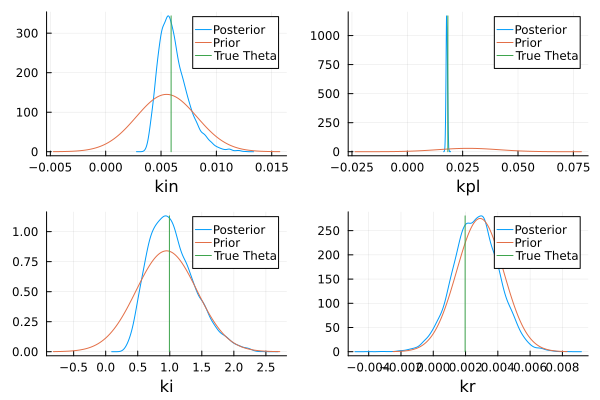

In [47]:
pp1 = plot(kde(poster[:,3]), label = "Posterior", xlabel = names[1])
plot!(Normal(0.0055, 0.00275), label = "Prior")
plot!([trueP[3], trueP[3]],[0, maximum(kde(poster[:,3]).density)], label = "True Theta")

pp2 = plot(kde(poster[:,4]), label = "Posterior", xlabel = names[2])
plot!(Normal(0.0275, 0.01375), label = "Prior")
plot!([trueP[4], trueP[4]],[0, maximum(kde(poster[:,4]).density)], label = "True Theta")

pp3 = plot(kde(poster[:,11]), label = "Posterior", xlabel = names[3])
plot!(Normal(0.95, 0.475), label = "Prior")
plot!([trueP[11], trueP[11]],[0, maximum(kde(poster[:,11]).density)], label = "True Theta")

pp4 = plot(kde(poster[:,12]), label = "Posterior", xlabel = names[4])
plot!(Normal(0.0029, 0.00145), label = "Prior")
plot!([trueP[12], trueP[12]],[0, maximum(kde(poster[:,12]).density)], label = "True Theta")

plot(pp1,pp2,pp3,pp4)

## Simulate Experiment Current Posterior

In [48]:
simsPoster = Array{Any}(undef, 8000);


for i in 1:8000
    tsC2 = dat["sts"];
    ts = 0:tsC2[end];
    ivss = [dat["Means"][1,1,1]/(sampsTh[i,end]*0.12), 0, 0, poster[i,14], poster[i,15], poster[i,16], 0, 0, 0, 0, 0, dat["Means"][1,1,1]/(sampsTh[i,end]*0.12), 0, dat["Means"][1,1,1]];;
    samps = convert.(Int, tsC2);

    SimulsAll, SimulsAll2, SimulsAll3 = PyruvateHP_NMR_SolveAllCp(ts, vcat(poster[i,1:13], 0), ivss, samps);

    simsPoster[i] = SimulsAll;
end

In [49]:
# Dims = Up/Down, Observable, Experiment
PostQuant = Array{Any}(undef,2,1,1);
lacPostSims = zeros(size(simsPoster[1])[1], 8000)
[lacPostSims[:,i] = simsPoster[i][:,13,1] for i in 1:8000 ];

for k in 1:1
    for m in 1:1
        PostQuant[1,k,m] = [percentile(lacPostSims[j,:], 99.5) for j in 1:size(lacPostSims)[1]]; # Up
        PostQuant[2,k,m] = [percentile(lacPostSims[j,:], 0.5 ) for j in 1:size(lacPostSims)[1]]; # Down
    end
end


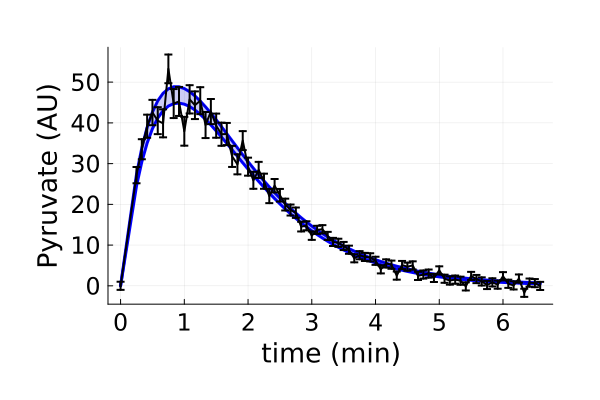

In [50]:
pr = plot(tsC2./60, PostQuant[1], label = "", color = "blue", linewidth = 3,
    margin=10Plots.mm,xtickfont=font(16), ytickfont=font(16), guidefont=font(18), titlefont=font(18),
    xlabel = "time (min)", ylabel = "Pyruvate (AU)")
  plot!(tsC2./60, PostQuant[2], label = "", color = "blue", linewidth = 3)
  plot!(tsC2./60, PostQuant[1], fillrange=PostQuant[2], label="", color="blue3", fillalpha=0.2)

  plot!(dat["sts"]./60, dat["Means"][:,1,2], yerror = dat["Erros"][:,1,2], linewidth = 2, colour = "black", label = "")

# Bayesian Inference 2

## Extract Data

In [9]:
mainpath = "C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\PseudoData\\";
i = 2;
paths = [mainpath*"CompReprFixedPars_Ran"*string(1)*"_Observables_Pyr"*(string(PyrCons[1]/1000))*"mM.csv",
         mainpath*"CompReprFixedPars_Ran"*string(2)*"_Observables_Pyr"*(string(PyrCons[2]/1000))*"mM.csv"]

2-element Vector{String}:
 "C:\\IBECPostDocDrive\\2024_01_16_" ⋯ 84 bytes ⋯ "_Ran1_Observables_Pyr13.8mM.csv"
 "C:\\IBECPostDocDrive\\2024_01_16_" ⋯ 83 bytes ⋯ "s_Ran2_Observables_Pyr0.8mM.csv"

In [10]:
Random.seed!(231549);
global dat = restructDatInfCompRep_FixedSF(paths, InitsY0[1], InitsY0[2], InitsY0[3], 15)

Dict{String, Any} with 14 entries:
  "Means"  => [24840.0 1440.0; 18883.6 1085.01; … ; 19.8071 -2.48291; 18.0714 -…
  "stsl"   => [78 78]
  "obSta"  => [1 2]
  "sts"    => [0 0; 15 15; … ; 390 390; 395 395]
  "obser"  => 2
  "Y0us"   => [13800.0 800.0; 0.0 0.0; … ; 0.0 0.0; 24840.0 1440.0]
  "ts"     => [1.0e-20 1.0e-20; 1.0 1.0; … ; 394.0 394.0; 395.0 395.0]
  "itp"    => [0.0, 0.0]
  "ncells" => [0 0]
  "stslm"  => 78
  "tml"    => 396
  "Erros"  => [2980.8 172.8; 2266.03 130.202; … ; 2.37686 1.0; 2.16857 1.0;;; 1…
  "m"      => 2
  "nts"    => [395 395]

## Prior Prediction

In [17]:
simsPrior = Array{Any}(undef, 8000);


for i in 1:8000
    tsC2 = dat["sts"][:,end];
    ts = 0:tsC2[end];
    ivss = [dat["Means"][1,end,1]/(sampsTh[i,end]*0.12), 0, 0, poster[i,14], poster[i,15], poster[i,16], 0, 0, 0, 0, 0, dat["Means"][1,end,1]/(sampsTh[i,end]*0.12), 0, dat["Means"][1,end,1]];;
    samps = convert.(Int, tsC2);

    SimulsAll, SimulsAll2, SimulsAll3 = PyruvateHP_NMR_SolveAllCp(ts, vcat(poster[i,1:13], 0), ivss, samps);

    simsPrior[i] = SimulsAll;
end

In [18]:
# Dims = Up/Down, Observable, Experiment
PriorQuant = Array{Any}(undef,2,1,1);
lacPirorSims = zeros(size(simsPrior[1])[1], 8000)
[lacPirorSims[:,i] = simsPrior[i][:,13,1] for i in 1:8000 ];

for k in 1:1
    for m in 1:1
        PriorQuant[1,k,m] = [percentile(lacPirorSims[j,:], 99.5) for j in 1:size(lacPirorSims)[1]]; # Up
        PriorQuant[2,k,m] = [percentile(lacPirorSims[j,:], 0.5 ) for j in 1:size(lacPirorSims)[1]]; # Down
    end
end


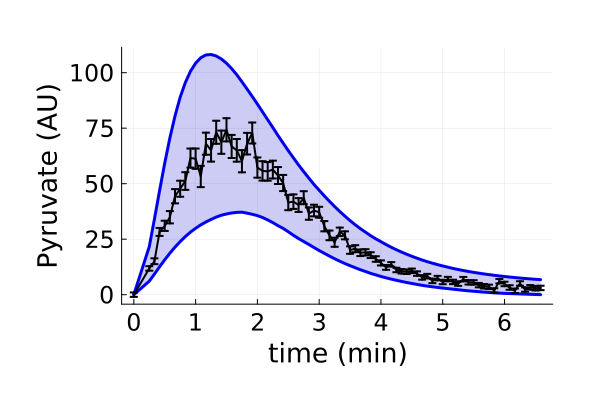

In [19]:
pr = plot(tsC2./60, PriorQuant[1], label = "", color = "blue", linewidth = 3,
    margin=10Plots.mm,xtickfont=font(16), ytickfont=font(16), guidefont=font(18), titlefont=font(18),
    xlabel = "time (min)", ylabel = "Pyruvate (AU)")
  plot!(tsC2./60, PriorQuant[2], label = "", color = "blue", linewidth = 3)
  plot!(tsC2./60, PriorQuant[1], fillrange=PriorQuant[2], label="", color="blue3", fillalpha=0.2)

  plot!(dat["sts"][:,end]./60, dat["Means"][:,end,2], yerror = dat["Erros"][:,end,2], linewidth = 2, colour = "black", label = "")

## MLE to obtain a good first guess for inference

In [20]:
function ObjectFunctMECp_Multi_MLE(p)

    # Define parameter vectors for each amount of cells (last parameter is a time delay, not used in here)
    pD2 = vcat(p[1:end-3], 0);
    obj = 0;
    
    for i in 1:length(dat["stsl"])
        # Define time vector
        t2cor = dat["sts"][:,i];

        # Define equaly-spaced time vector
        ts1 = collect(0:t2cor[end]);

        # Define initial value for simulation (use of experimental mean)
        ivss1 = [dat["Means"][1,i,1]/(ScFm*0.12), 0, dat["Means"][1,i,2]/(ScFm*0.12), p[end-2], p[end-1], p[end], 0, 0, 0, 0, 0, dat["Means"][1,i,1]/(ScFm*0.12), dat["Means"][1,i,2], dat["Means"][1,i,1]];

        # Convert sampling vector to integer to extract correct elements from simulation
        samps1 = convert.(Int, t2cor);

        # Simulate
        SimOnTime1, SimOffTime1, SimAll1  = PyruvateHP_NMR_SolveAllCp(ts1, pD2, ivss1, samps1);
    
        mm22 = sum((-1/2) .* (log(2*pi) .+ log.(dat["Erros"][:,i,2].^2) .+ ((SimOnTime1[:,13] .- dat["Means"][:,i,2]).^2)./(dat["Erros"][:,i,2].^2)));

        # obj = (mm21+mm22)*(mm11+mm12);
        if p[end-2] >= p[end-1]
            mm22 = mm22*10;
        end
        obj = -(mm22)+obj;
    end
    
    return(obj)

end

ObjectFunctMECp_Multi_MLE (generic function with 1 method)

In [21]:
global ScFm = 15;
p = [48, 55, 0.044, 0.02, 0.02, 0.001, 0.01, 0.0003, 0.0001, 0.0002, 1e-1, 1e-6, 15, 50/(15*0.12), 5000/(15*0.12), 700/(15*0.12)];
ObjectFunctMECp_Multi_MLE(p)

5075.226099354913

In [22]:
Iters = 1;
CCsT = Array{Any}(undef,Iters);
FitsT = Array{Any}(undef,Iters);

In [23]:
i=1
fitness_progress_history = Array{Tuple{Int, Float64},1}()
callback = oc -> push!(fitness_progress_history, (num_func_evals(oc), best_fitness(oc)))

resM = bboptimize(ObjectFunctMECp_Multi_MLE; SearchRange = vcat([(bounds[1][i], bounds[2][i]) for i in 1:13], [(boundY0[1][i], boundY0[2][i]) for i in 1:3]), # T1_X, T1_P, kin, kpl, kf, kr, a1, a2, a3, b1, b2, b3
        MaxTime = 60*2, method = :adaptive_de_rand_1_bin, 
        CallbackFunction = callback, CallbackInterval = 0.0)

CCsT[i] = fitness_progress_history;
FitsT[i] = resM;

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.53 secs, 60 evals, 33 steps, improv/step: 0.394 (last = 0.3939), fitness=342.792893579
1.04 secs, 110 evals, 65 steps, improv/step: 0.354 (last = 0.3125), fitness=342.792893579
1.56 secs, 166 evals, 103 steps, improv/step: 0.359 (last = 0.3684), fitness=341.980900150
2.10 secs, 237 evals, 158 steps, improv/step: 0.348 (last = 0.3273), fitness=341.980900150
2.62 secs, 309 evals, 230 steps, improv/step: 0.348 (last = 0.3472), fitness=303.100732257
3.12 secs, 385 evals, 315 steps, improv/step: 0.333 (last = 0.2941), fitness=303.100732257
3.63 secs, 460 evals, 389 steps, improv/step: 0.347 (last = 0.4054), fitness=303.100732257
4.13 secs, 540 evals, 472 steps, improv/step: 0.341 (last = 0.3133), fitness=303.100732257
4.64 secs, 610 evals, 549 steps, improv/step: 0.322 (last = 0.2078), fi

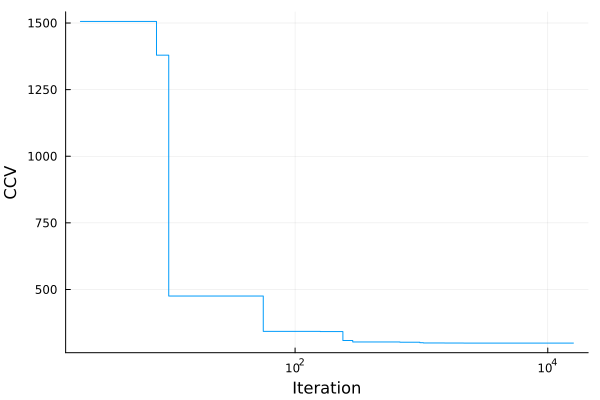

In [24]:
# Plot convergence curve
pl=plot(CCsT[1], xaxis=:log, linetype=:step, label = "", xlabel = "Iteration", ylabel = "CCV")
display(pl)

In [25]:
parfitT = zeros(16, Iters);
for i in 1:Iters
    parfitT[:,i] = best_candidate(FitsT[i]);
end
bestPind = findfirst([CCsT[i][end][2] for i in 1:length(CCsT)] .== minimum([CCsT[i][end][2] for i in 1:length(CCsT)]))
ppT = parfitT[:,bestPind]

16-element Vector{Float64}:
    48.0
    55.0
     0.005987325021691176
     0.017892267016344086
     0.042171
     0.5365
     0.98047
     0.991257
     0.93335
     0.008241
     0.9512414689596024
     0.001531454452728996
    15.0
   450.0
 12599.0
   226.0

In [26]:
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\MLEResults\\resMTRRCmpFP_ScF_Rand2.jld2", "FitsT",FitsT)
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\MLEResults\\resMVectTRRCmpFP_ScF_Rand2.jld2", 
        "resMMat",parfitT, "CCsT", CCsT)

In [27]:
ppT = JLD2.load("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\MLEResults\\resMVectTRRCmpFP_ScF_Rand2.jld2")["resMMat"][:,1]


16-element Vector{Float64}:
    48.0
    55.0
     0.005987325021691176
     0.017892267016344086
     0.042171
     0.5365
     0.98047
     0.991257
     0.93335
     0.008241
     0.9512414689596024
     0.001531454452728996
    15.0
   450.0
 12599.0
   226.0

## Compute structure for Stan's initial guess

In [28]:
preTrans = zeros(4);


preTrans[1] = (ppT[3]-0.0055)/0.00275; 
preTrans[2] = (ppT[4]-0.0275)/0.01375;          
preTrans[3] = (ppT[11]-0.95)/0.475;
preTrans[4] = (ppT[12]-0.0029)/0.00145;

In [29]:

samps = hcat(preTrans,preTrans,preTrans,preTrans);
names = ["kin","kpl","ki","kr"];

ini = genStanInitDict(samps, names, 4)

4-element Vector{Dict{String, Any}}:
 Dict("kin" => 0.17720909879679128, "kr" => -0.943824515359313, "ki" => 0.002613618862320886, "kpl" => -0.6987442169931574)
 Dict("kin" => 0.17720909879679128, "kr" => -0.943824515359313, "ki" => 0.002613618862320886, "kpl" => -0.6987442169931574)
 Dict("kin" => 0.17720909879679128, "kr" => -0.943824515359313, "ki" => 0.002613618862320886, "kpl" => -0.6987442169931574)
 Dict("kin" => 0.17720909879679128, "kr" => -0.943824515359313, "ki" => 0.002613618862320886, "kpl" => -0.6987442169931574)

In [30]:
ini[1]

Dict{String, Any} with 4 entries:
  "kin" => 0.177209
  "kr"  => -0.943825
  "ki"  => 0.00261362
  "kpl" => -0.698744

## Inference

In [31]:
modelpath = "C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\HP_PyrLac_CompetitiveRepressionModel_FixedT1ScF_FixedParsMulti.stan";
stream = open(modelpath,"r");
Model = read(stream,String);
close(stream);

StanModel = Stanmodel(name="PyrCompReprFP_Rand2_Try1", model=Model, nchains =4,
            num_samples  = 2000, num_warmup = 1000, printsummary=true);
StanModel.method.save_warmup = true;
StanModel.method.adapt.delta = 0.85;
StanModel.method.algorithm.stepsize = 0.1;
StanModel.method.algorithm.engine.max_depth=10;
StanModel.method.algorithm.stepsize_jitter = 0.5;

In [32]:
rc, chns, cnames = stan(StanModel, dat, init = ini) 


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: CVode(cvodes_mem, t_final, nv_state_, &t_init, CV_NORMAL) failed with error flag -1: 
The solver took mxstep internal steps but could not reach tout. (in 'c:/IBECPostDocDrive/2024_01_16_NCvsKR/DataProcessingInference/ComputationalBayesianOED/tmp/PyrCompReprFP_Rand2_Try1.stan', line 178, column 6 to column 135)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: CVode(cvodes_mem, t_final, nv_state_, &t_init, CV_NORMAL) failed with error flag -4: 
Convergence test failures occurred too many times during one internal time step or minimum step size was reached. (in

(0, [-300.721 0.933259 … 12599.0 226.0; -300.721 0.0 … 12599.0 226.0; … ; -303.728 1.0 … 12599.0 226.0; -302.151 0.949503 … 12599.0 226.0;;; -299.547 0.000212656 … 12599.0 226.0; -299.547 0.0 … 12599.0 226.0; … ; -300.408 0.999417 … 12599.0 226.0; -301.382 0.999004 … 12599.0 226.0;;; -300.525 0.833146 … 12599.0 226.0; -300.525 0.0 … 12599.0 226.0; … ; -301.462 0.97197 … 12599.0 226.0; -302.104 0.987515 … 12599.0 226.0;;; -300.134 0.993903 … 12599.0 226.0; -300.134 0.0 … 12599.0 226.0; … ; -302.613 0.98988 … 12599.0 226.0; -302.021 0.398283 … 12599.0 226.0], ["lp__", "accept_stat__", "stepsize__", "treedepth__", "n_leapfrog__", "divergent__", "energy__", "kin", "kpl", "ki"  …  "theta.7", "theta.8", "theta.9", "theta.10", "theta.11", "theta.12", "theta.13", "inits.1", "inits.2", "inits.3"])

In [33]:
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PyrCompetitiveRepressionInferResFixedPars_Rand2_Try1.jld", "rc", rc, "chns", chns, "cnames", cnames)

In [34]:
poster = vcat(chns[1001:end, end-15:end, 1], chns[1001:end, end-15:end, 2], chns[1001:end, end-15:end, 3], chns[1001:end, end-15:end, 4])
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_Rand2_Try1.jld", "poster", poster)
CSV.write("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_Rand2_Try1.csv", DataFrame(poster, :auto))

"C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_Rand2_Try1.csv"

In [35]:
poster = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_Rand2_Try1.csv", DataFrame))

8000×16 Matrix{Float64}:
 48.0  55.0  0.00586363  0.0179878  0.042171  …  15.0  450.0  12599.0  226.0
 48.0  55.0  0.00610862  0.0179435  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00610604  0.0178257  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00593542  0.0179257  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00610937  0.0180368  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00586821  0.0179907  0.042171  …  15.0  450.0  12599.0  226.0
 48.0  55.0  0.00591305  0.0184661  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00580596  0.0176535  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00585152  0.0182999  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00591596  0.0177021  0.042171     15.0  450.0  12599.0  226.0
  ⋮                                           ⋱                          ⋮
 48.0  55.0  0.00587026  0.0176442  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00613344  0.0181901  0.042171     15.0

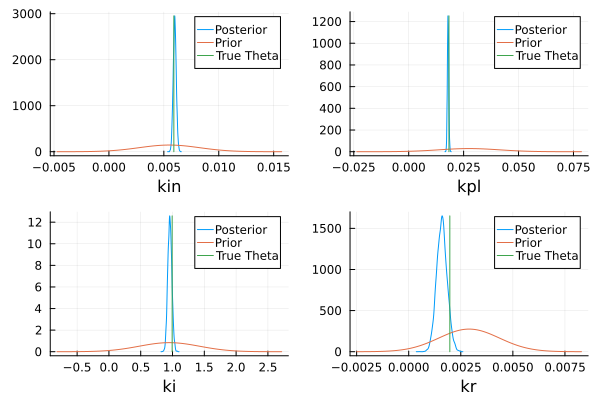

In [36]:
pp1 = plot(kde(poster[:,3]), label = "Posterior", xlabel = names[1])
plot!(Normal(0.0055, 0.00275), label = "Prior")
plot!([trueP[3], trueP[3]],[0, maximum(kde(poster[:,3]).density)], label = "True Theta")

pp2 = plot(kde(poster[:,4]), label = "Posterior", xlabel = names[2])
plot!(Normal(0.0275, 0.01375), label = "Prior")
plot!([trueP[4], trueP[4]],[0, maximum(kde(poster[:,4]).density)], label = "True Theta")

pp3 = plot(kde(poster[:,11]), label = "Posterior", xlabel = names[3])
plot!(Normal(0.95, 0.475), label = "Prior")
plot!([trueP[11], trueP[11]],[0, maximum(kde(poster[:,11]).density)], label = "True Theta")

pp4 = plot(kde(poster[:,12]), label = "Posterior", xlabel = names[4])
plot!(Normal(0.0029, 0.00145), label = "Prior")
plot!([trueP[12], trueP[12]],[0, maximum(kde(poster[:,12]).density)], label = "True Theta")

plot(pp1,pp2,pp3,pp4)

## Simulate Experiment Current Posterior

In [37]:
simsPoster = Array{Any}(undef, 8000);


for i in 1:8000
    tsC2 = dat["sts"][:,end];
    ts = 0:tsC2[end];
    ivss = [dat["Means"][1,end,1]/(sampsTh[i,end]*0.12), 0, 0, poster[i,14], poster[i,15], poster[i,16], 0, 0, 0, 0, 0, dat["Means"][1,end,1]/(sampsTh[i,end]*0.12), 0, dat["Means"][1,end,1]];;
    samps = convert.(Int, tsC2);

    SimulsAll, SimulsAll2, SimulsAll3 = PyruvateHP_NMR_SolveAllCp(ts, vcat(poster[i,1:13], 0), ivss, samps);

    simsPoster[i] = SimulsAll;
end

In [38]:
# Dims = Up/Down, Observable, Experiment
PostQuant = Array{Any}(undef,2,1,1);
lacPostSims = zeros(size(simsPoster[1])[1], 8000)
[lacPostSims[:,i] = simsPoster[i][:,13,1] for i in 1:8000 ];

for k in 1:1
    for m in 1:1
        PostQuant[1,k,m] = [percentile(lacPostSims[j,:], 99.5) for j in 1:size(lacPostSims)[1]]; # Up
        PostQuant[2,k,m] = [percentile(lacPostSims[j,:], 0.5 ) for j in 1:size(lacPostSims)[1]]; # Down
    end
end


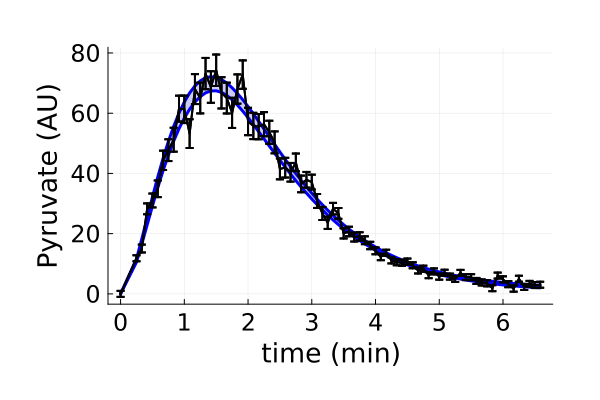

In [39]:
pr = plot(tsC2./60, PostQuant[1], label = "", color = "blue", linewidth = 3,
    margin=10Plots.mm,xtickfont=font(16), ytickfont=font(16), guidefont=font(18), titlefont=font(18),
    xlabel = "time (min)", ylabel = "Pyruvate (AU)")
  plot!(tsC2./60, PostQuant[2], label = "", color = "blue", linewidth = 3)
  plot!(tsC2./60, PostQuant[1], fillrange=PostQuant[2], label="", color="blue3", fillalpha=0.2)

  plot!(dat["sts"]./60, dat["Means"][:,end,2], yerror = dat["Erros"][:,end,2], linewidth = 2, colour = "black", label = "")

# Bayesian Inference 3

## Extract Data

In [40]:
mainpath = "C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\PseudoData\\";
i = 3;
paths = [mainpath*"CompReprFixedPars_Ran"*string(1)*"_Observables_Pyr"*(string(PyrCons[1]/1000))*"mM.csv",
         mainpath*"CompReprFixedPars_Ran"*string(2)*"_Observables_Pyr"*(string(PyrCons[2]/1000))*"mM.csv",
         mainpath*"CompReprFixedPars_Ran"*string(3)*"_Observables_Pyr"*(string(PyrCons[3]/1000))*"mM.csv"]

3-element Vector{String}:
 "C:\\IBECPostDocDrive\\2024_01_16_" ⋯ 84 bytes ⋯ "_Ran1_Observables_Pyr13.8mM.csv"
 "C:\\IBECPostDocDrive\\2024_01_16_" ⋯ 83 bytes ⋯ "s_Ran2_Observables_Pyr0.8mM.csv"
 "C:\\IBECPostDocDrive\\2024_01_16_" ⋯ 84 bytes ⋯ "_Ran3_Observables_Pyr29.4mM.csv"

In [41]:
Random.seed!(231549);
global dat = restructDatInfCompRep_FixedSF(paths, InitsY0[1], InitsY0[2], InitsY0[3], 15)

Dict{String, Any} with 14 entries:
  "Means"  => [24840.0 1440.0 52920.0; 18883.6 1085.01 40266.6; … ; 19.8071 -2.…
  "stsl"   => [78 78 78]
  "obSta"  => [1 2]
  "sts"    => [0 0 0; 15 15 15; … ; 390 390 390; 395 395 395]
  "obser"  => 2
  "Y0us"   => [13800.0 800.0 29400.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 24840.0 144…
  "ts"     => [1.0e-20 1.0e-20 1.0e-20; 1.0 1.0 1.0; … ; 394.0 394.0 394.0; 395…
  "itp"    => [0.0, 0.0, 0.0]
  "ncells" => [0 0 0]
  "stslm"  => 78
  "tml"    => 396
  "Erros"  => [2980.8 172.8 6350.4; 2266.03 130.202 4831.99; … ; 2.37686 1.0 5.…
  "m"      => 3
  "nts"    => [395 395 395]

## Prior Prediction

In [42]:
simsPrior = Array{Any}(undef, 8000);


for i in 1:8000
    tsC2 = dat["sts"][:,end];
    ts = 0:tsC2[end];
    ivss = [dat["Means"][1,end,1]/(sampsTh[i,end]*0.12), 0, 0, poster[i,14], poster[i,15], poster[i,16], 0, 0, 0, 0, 0, dat["Means"][1,end,1]/(sampsTh[i,end]*0.12), 0, dat["Means"][1,end,1]];;
    samps = convert.(Int, tsC2);

    SimulsAll, SimulsAll2, SimulsAll3 = PyruvateHP_NMR_SolveAllCp(ts, vcat(poster[i,1:13], 0), ivss, samps);

    simsPrior[i] = SimulsAll;
end

In [43]:
# Dims = Up/Down, Observable, Experiment
PriorQuant = Array{Any}(undef,2,1,1);
lacPirorSims = zeros(size(simsPrior[1])[1], 8000)
[lacPirorSims[:,i] = simsPrior[i][:,13,1] for i in 1:8000 ];

for k in 1:1
    for m in 1:1
        PriorQuant[1,k,m] = [percentile(lacPirorSims[j,:], 99.5) for j in 1:size(lacPirorSims)[1]]; # Up
        PriorQuant[2,k,m] = [percentile(lacPirorSims[j,:], 0.5 ) for j in 1:size(lacPirorSims)[1]]; # Down
    end
end


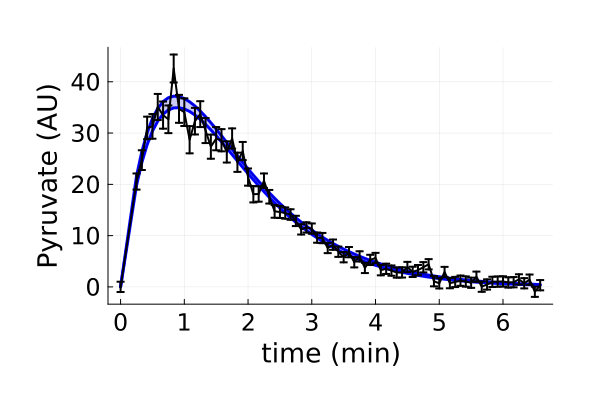

In [44]:
pr = plot(tsC2./60, PriorQuant[1], label = "", color = "blue", linewidth = 3,
    margin=10Plots.mm,xtickfont=font(16), ytickfont=font(16), guidefont=font(18), titlefont=font(18),
    xlabel = "time (min)", ylabel = "Pyruvate (AU)")
  plot!(tsC2./60, PriorQuant[2], label = "", color = "blue", linewidth = 3)
  plot!(tsC2./60, PriorQuant[1], fillrange=PriorQuant[2], label="", color="blue3", fillalpha=0.2)

  plot!(dat["sts"][:,end]./60, dat["Means"][:,end,2], yerror = dat["Erros"][:,end,2], linewidth = 2, colour = "black", label = "")

## MLE to obtain a good first guess for inference

In [45]:
global ScFm = 15;
p = [48, 55, 0.044, 0.02, 0.02, 0.001, 0.01, 0.0003, 0.0001, 0.0002, 1e-1, 1e-6, 15, 50/(15*0.12), 5000/(15*0.12), 700/(15*0.12)];
ObjectFunctMECp_Multi_MLE(p)

6503.505471938519

In [46]:
Iters = 1;
CCsT = Array{Any}(undef,Iters);
FitsT = Array{Any}(undef,Iters);

In [47]:
i=1
fitness_progress_history = Array{Tuple{Int, Float64},1}()
callback = oc -> push!(fitness_progress_history, (num_func_evals(oc), best_fitness(oc)))

resM = bboptimize(ObjectFunctMECp_Multi_MLE; SearchRange = vcat([(minimum(abs.(poster[:,i])), maximum(abs.(poster[:,i]))) for i in 1:13], 
                                        [(minimum(abs.(poster[:,i])), maximum(abs.(poster[:,i]))) for i in 14:16]), # T1_X, T1_P, kin, kpl, kf, kr, a1, a2, a3, b1, b2, b3
        MaxTime = 60*2, method = :adaptive_de_rand_1_bin, 
        CallbackFunction = callback, CallbackInterval = 0.0)

CCsT[i] = fitness_progress_history;
FitsT[i] = resM;

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.52 secs, 35 evals, 18 steps, improv/step: 0.278 (last = 0.2778), fitness=429.805892951
1.07 secs, 60 evals, 31 steps, improv/step: 0.258 (last = 0.2308), fitness=428.175842132
1.67 secs, 83 evals, 44 steps, improv/step: 0.409 (last = 0.7692), fitness=427.476228922
2.18 secs, 110 evals, 60 steps, improv/step: 0.367 (last = 0.2500), fitness=427.476228922
2.71 secs, 146 evals, 82 steps, improv/step: 0.378 (last = 0.4091), fitness=424.975673647
3.21 secs, 175 evals, 108 steps, improv/step: 0.370 (last = 0.3462), fitness=424.975673647
3.73 secs, 212 evals, 132 steps, improv/step: 0.364 (last = 0.3333), fitness=424.975673647
4.24 secs, 248 evals, 160 steps, improv/step: 0.369 (last = 0.3929), fitness=424.975673647
4.76 secs, 286 evals, 193 steps, improv/step: 0.358 (last = 0.3030), fitness

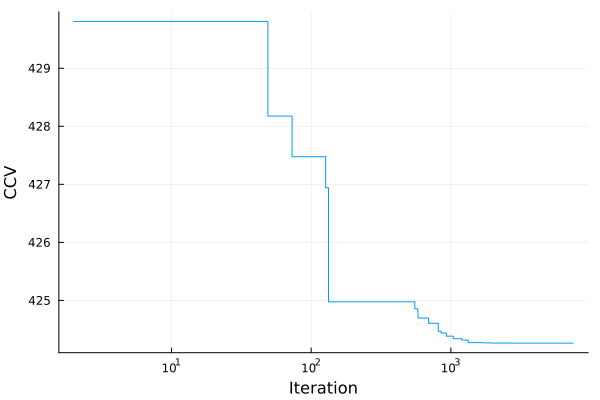

In [48]:
# Plot convergence curve
pl=plot(CCsT[1], xaxis=:log, linetype=:step, label = "", xlabel = "Iteration", ylabel = "CCV")
display(pl)

In [49]:
parfitT = zeros(16, Iters);
for i in 1:Iters
    parfitT[:,i] = best_candidate(FitsT[i]);
end
bestPind = findfirst([CCsT[i][end][2] for i in 1:length(CCsT)] .== minimum([CCsT[i][end][2] for i in 1:length(CCsT)]))
ppT = parfitT[:,bestPind]

16-element Vector{Float64}:
    48.0
    55.0
     0.006040315668007647
     0.01799646588177539
     0.042171
     0.5365
     0.98047
     0.991257
     0.93335
     0.008241
     0.9736419215782814
     0.0017392264433373401
    15.0
   450.0
 12599.0
   226.0

In [50]:
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\MLEResults\\resMTRRCmpFP_ScF_Rand3.jld2", "FitsT",FitsT)
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\MLEResults\\resMVectTRRCmpFP_ScF_Rand3.jld2", 
        "resMMat",parfitT, "CCsT", CCsT)

In [51]:
ppT = JLD2.load("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\MLEResults\\resMVectTRRCmpFP_ScF_Rand3.jld2")["resMMat"][:,1]


16-element Vector{Float64}:
    48.0
    55.0
     0.006040315668007647
     0.01799646588177539
     0.042171
     0.5365
     0.98047
     0.991257
     0.93335
     0.008241
     0.9736419215782814
     0.0017392264433373401
    15.0
   450.0
 12599.0
   226.0

## Compute structure for Stan's initial guess

In [52]:
preTrans = zeros(4);


preTrans[1] = (ppT[3]-0.0055)/0.00275; 
preTrans[2] = (ppT[4]-0.0275)/0.01375;          
preTrans[3] = (ppT[11]-0.95)/0.475;
preTrans[4] = (ppT[12]-0.0029)/0.00145;

In [53]:

samps = hcat(preTrans,preTrans,preTrans,preTrans);
names = ["kin","kpl","ki","kr"];

ini = genStanInitDict(samps, names, 4)

4-element Vector{Dict{String, Any}}:
 Dict("kin" => 0.19647842473005347, "kr" => -0.8005334873535584, "ki" => 0.04977246648059261, "kpl" => -0.6911661176890627)
 Dict("kin" => 0.19647842473005347, "kr" => -0.8005334873535584, "ki" => 0.04977246648059261, "kpl" => -0.6911661176890627)
 Dict("kin" => 0.19647842473005347, "kr" => -0.8005334873535584, "ki" => 0.04977246648059261, "kpl" => -0.6911661176890627)
 Dict("kin" => 0.19647842473005347, "kr" => -0.8005334873535584, "ki" => 0.04977246648059261, "kpl" => -0.6911661176890627)

In [54]:
ini[1]

Dict{String, Any} with 4 entries:
  "kin" => 0.196478
  "kr"  => -0.800533
  "ki"  => 0.0497725
  "kpl" => -0.691166

## Inference

In [55]:
modelpath = "C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\HP_PyrLac_CompetitiveRepressionModel_FixedT1ScF_FixedParsMulti.stan";
stream = open(modelpath,"r");
Model = read(stream,String);
close(stream);

StanModel = Stanmodel(name="PyrCompReprFP_Rand2_Try1", model=Model, nchains =4,
            num_samples  = 2000, num_warmup = 1000, printsummary=true);
StanModel.method.save_warmup = true;
StanModel.method.adapt.delta = 0.85;
StanModel.method.algorithm.stepsize = 0.1;
StanModel.method.algorithm.engine.max_depth=10;
StanModel.method.algorithm.stepsize_jitter = 0.5;

In [56]:
rc, chns, cnames = stan(StanModel, dat, init = ini) 


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: CVode(cvodes_mem, t_final, nv_state_, &t_init, CV_NORMAL) failed with error flag -1: 
The solver took mxstep internal steps but could not reach tout. (in 'c:/IBECPostDocDrive/2024_01_16_NCvsKR/DataProcessingInference/ComputationalBayesianOED/tmp/PyrCompReprFP_Rand2_Try1.stan', line 178, column 6 to column 135)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: CVode(cvodes_mem, t_final, nv_state_, &t_init, CV_NORMAL) failed with error flag -4: 
Convergence test failures occurred too many times during one internal time step or minimum step size was reached. (in

(0, [-424.845 0.0453202 … 12599.0 226.0; -424.845 0.0 … 12599.0 226.0; … ; -426.633 0.984178 … 12599.0 226.0; -429.955 0.883039 … 12599.0 226.0;;; -425.06 0.967062 … 12599.0 226.0; -425.06 0.0 … 12599.0 226.0; … ; -426.493 0.998565 … 12599.0 226.0; -427.754 0.88379 … 12599.0 226.0;;; -425.25 0.837867 … 12599.0 226.0; -425.25 0.0 … 12599.0 226.0; … ; -426.985 0.990949 … 12599.0 226.0; -426.386 0.986926 … 12599.0 226.0;;; -425.571 0.985632 … 12599.0 226.0; -425.571 0.0 … 12599.0 226.0; … ; -426.25 0.934287 … 12599.0 226.0; -427.113 0.911745 … 12599.0 226.0], ["lp__", "accept_stat__", "stepsize__", "treedepth__", "n_leapfrog__", "divergent__", "energy__", "kin", "kpl", "ki"  …  "theta.7", "theta.8", "theta.9", "theta.10", "theta.11", "theta.12", "theta.13", "inits.1", "inits.2", "inits.3"])

In [57]:
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PyrCompetitiveRepressionInferResFixedPars_Rand3_Try1.jld", "rc", rc, "chns", chns, "cnames", cnames)

In [58]:
poster = vcat(chns[1001:end, end-15:end, 1], chns[1001:end, end-15:end, 2], chns[1001:end, end-15:end, 3], chns[1001:end, end-15:end, 4])
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_Rand3_Try1.jld", "poster", poster)
CSV.write("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_Rand3_Try1.csv", DataFrame(poster, :auto))

"C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_Rand3_Try1.csv"

In [59]:
poster = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_Rand3_Try1.csv", DataFrame))

8000×16 Matrix{Float64}:
 48.0  55.0  0.00593875  0.0178966  0.042171  …  15.0  450.0  12599.0  226.0
 48.0  55.0  0.00597612  0.0183661  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00582241  0.0182833  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00624029  0.0177236  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00601923  0.0179958  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00588378  0.0181712  0.042171  …  15.0  450.0  12599.0  226.0
 48.0  55.0  0.00582856  0.0180089  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00591412  0.0181438  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00588217  0.0182383  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00588776  0.0180973  0.042171     15.0  450.0  12599.0  226.0
  ⋮                                           ⋱                          ⋮
 48.0  55.0  0.00621744  0.0182356  0.042171     15.0  450.0  12599.0  226.0
 48.0  55.0  0.00608474  0.0177918  0.042171     15.0

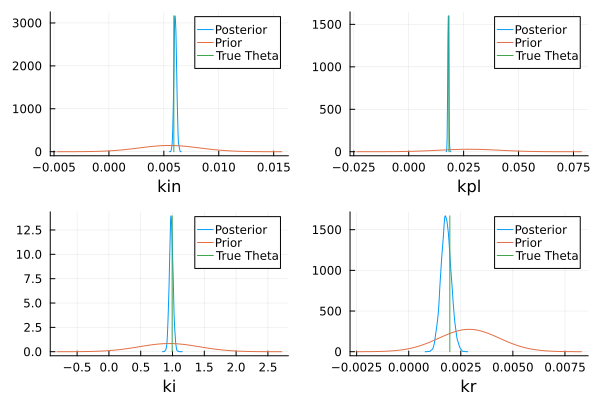

In [61]:
pp1 = plot(kde(poster[:,3]), label = "Posterior", xlabel = names[1])
plot!(Normal(0.0055, 0.00275), label = "Prior")
plot!([trueP[3], trueP[3]],[0, maximum(kde(poster[:,3]).density)], label = "True Theta")

pp2 = plot(kde(poster[:,4]), label = "Posterior", xlabel = names[2])
plot!(Normal(0.0275, 0.01375), label = "Prior")
plot!([trueP[4], trueP[4]],[0, maximum(kde(poster[:,4]).density)], label = "True Theta")

pp3 = plot(kde(poster[:,11]), label = "Posterior", xlabel = names[3])
plot!(Normal(0.95, 0.475), label = "Prior")
plot!([trueP[11], trueP[11]],[0, maximum(kde(poster[:,11]).density)], label = "True Theta")

pp4 = plot(kde(poster[:,12]), label = "Posterior", xlabel = names[4])
plot!(Normal(0.0029, 0.00145), label = "Prior")
plot!([trueP[12], trueP[12]],[0, maximum(kde(poster[:,12]).density)], label = "True Theta")

plot(pp1,pp2,pp3,pp4)

## Simulate Experiment Current Posterior

In [63]:
simsPoster = Array{Any}(undef, 8000);


for i in 1:8000
    tsC2 = dat["sts"][:,end];
    ts = 0:tsC2[end];
    ivss = [dat["Means"][1,end,1]/(sampsTh[i,end]*0.12), 0, 0, poster[i,14], poster[i,15], poster[i,16], 0, 0, 0, 0, 0, dat["Means"][1,end,1]/(sampsTh[i,end]*0.12), 0, dat["Means"][1,end,1]];;
    samps = convert.(Int, tsC2);

    SimulsAll, SimulsAll2, SimulsAll3 = PyruvateHP_NMR_SolveAllCp(ts, vcat(poster[i,1:13], 0), ivss, samps);

    simsPoster[i] = SimulsAll;
end

In [64]:
# Dims = Up/Down, Observable, Experiment
PostQuant = Array{Any}(undef,2,1,1);
lacPostSims = zeros(size(simsPoster[1])[1], 8000)
[lacPostSims[:,i] = simsPoster[i][:,13,1] for i in 1:8000 ];

for k in 1:1
    for m in 1:1
        PostQuant[1,k,m] = [percentile(lacPostSims[j,:], 99.5) for j in 1:size(lacPostSims)[1]]; # Up
        PostQuant[2,k,m] = [percentile(lacPostSims[j,:], 0.5 ) for j in 1:size(lacPostSims)[1]]; # Down
    end
end


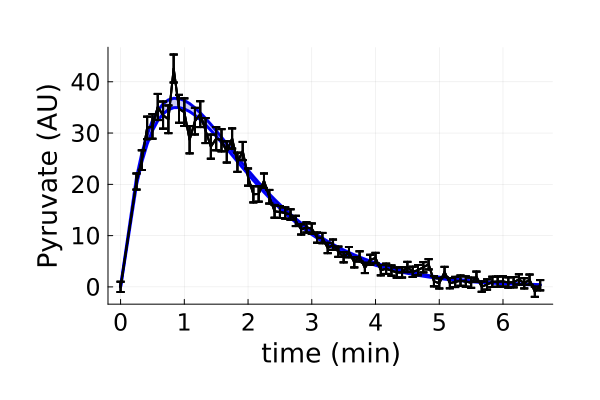

In [66]:
pr = plot(tsC2./60, PostQuant[1], label = "", color = "blue", linewidth = 3,
    margin=10Plots.mm,xtickfont=font(16), ytickfont=font(16), guidefont=font(18), titlefont=font(18),
    xlabel = "time (min)", ylabel = "Pyruvate (AU)")
  plot!(tsC2./60, PostQuant[2], label = "", color = "blue", linewidth = 3)
  plot!(tsC2./60, PostQuant[1], fillrange=PostQuant[2], label="", color="blue3", fillalpha=0.2)

  plot!(dat["sts"]./60, dat["Means"][:,end,2], yerror = dat["Erros"][:,end,2], linewidth = 2, colour = "black", label = "")

# Posterior Checks

In [68]:
posterO1 = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_OED1_Try2.csv", DataFrame));
posterR1 = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_Rand1_Try1.csv", DataFrame));
posterI1 = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_ID1_Try1.csv", DataFrame));

posterO2 = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_OED2_Try2.csv", DataFrame));
posterR2 = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_Rand2_Try1.csv", DataFrame));
posterI2 = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_ID2_Try1.csv", DataFrame));

posterO3 = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_OED3_Try2.csv", DataFrame));
posterR3 = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_Rand3_Try1.csv", DataFrame));
posterI3 = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepressionFixedPars_ID3_Try1.csv", DataFrame));

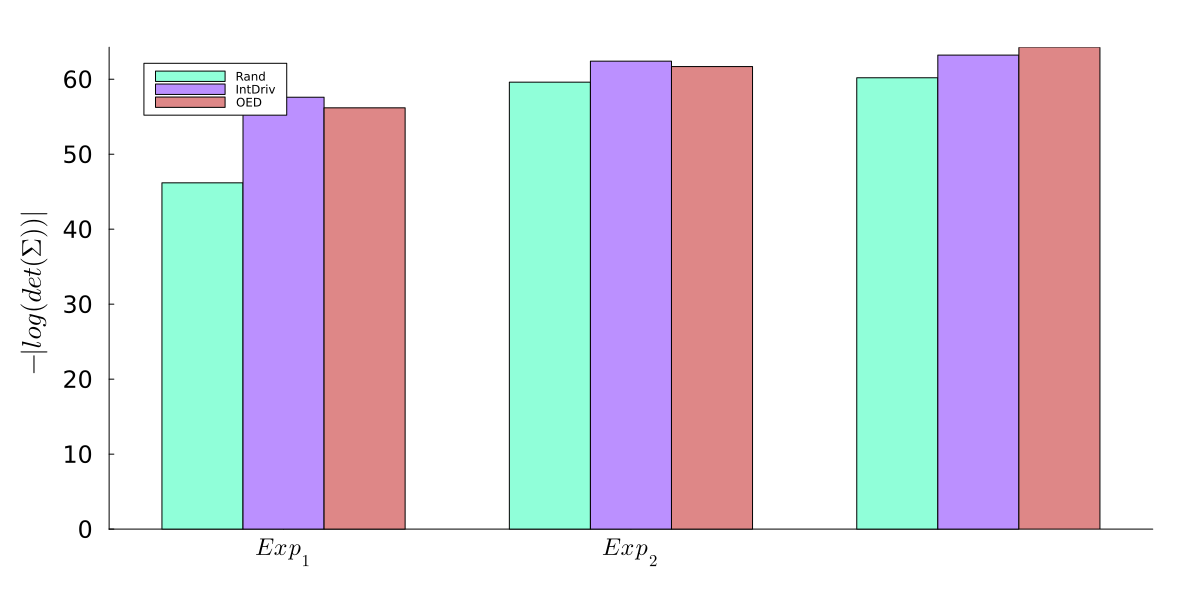

In [69]:
cvO = [-log(det(cov(hcat(posterO1[:,3:4], posterO1[:,11:12])))), -log(det(cov(hcat(posterO2[:,3:4], posterO2[:,11:12])))), -log(det(cov(hcat(posterO3[:,3:4], posterO3[:,11:12]))))];
cvR = [-log(det(cov(hcat(posterR1[:,3:4], posterR1[:,11:12])))), -log(det(cov(hcat(posterR2[:,3:4], posterR2[:,11:12])))), -log(det(cov(hcat(posterR3[:,3:4], posterR3[:,11:12]))))];
cvI = [-log(det(cov(hcat(posterI1[:,3:4], posterI1[:,11:12])))), -log(det(cov(hcat(posterI2[:,3:4], posterI2[:,11:12])))), -log(det(cov(hcat(posterI3[:,3:4], posterI3[:,11:12]))))];

groupedbar(abs.([cvR cvI cvO]) , bar_position = :dodge, bar_width=0.7, label = ["Rand" "IntDriv" "OED"], colour = ["#90ffd9ff" "#bb90ffff" "#de8787ff"], xticks = (1:2, [L"Exp_1", L"Exp_2"]), 
        ylabel = L"-|log(det(\Sigma))|", margin=10Plots.mm,xtickfont=font(16), ytickfont=font(16), guidefont=font(18), titlefont=font(18),
        size = (1200,600), grid = false)